# 🌳 Decision Tree Classification (SKLearn & Custom)

In this notebook, we explore Decision Tree classification using:

- **Synthetic data** with Gaussian noise
- **SKLearn's `DecisionTreeClassifier`**
- A **custom implementation of a binary decision tree**
  
Evaluation metrics and visualizations are included to compare both implementations.

In [128]:
from typing import Any, Literal

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from colorama import Fore, Style
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## 🛠️ Utils

In [129]:
def evaluate_classification(
    y_true: NDArray[np.int64], y_pred: NDArray[np.int64]
) -> dict[str, float]:
    """Print and return classification metrics.

    Args:
        y_true (NDArray[np.int64]): Ground truth labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        dict[str, float]: Dictionary with accuracy, precision, recall, and F1-score.
    """
    accuracy: float = accuracy_score(y_true, y_pred)
    precision: float = precision_score(
        y_true, y_pred, average="weighted", zero_division=0
    )
    recall: float = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1: float = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"{Fore.CYAN}Accuracy:  {Style.RESET_ALL}{accuracy:.4f}")
    print(f"{Fore.CYAN}Precision: {Style.RESET_ALL}{precision:.4f}")
    print(f"{Fore.CYAN}Recall:    {Style.RESET_ALL}{recall:.4f}")
    print(f"{Fore.CYAN}F1 Score:  {Style.RESET_ALL}{f1:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [130]:
def plot_confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> None:
    """Display a confusion matrix using seaborn heatmap.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


def plot_clusters(
    data: NDArray[np.float64],
    centers: NDArray[np.float64],
    X_test: NDArray[np.float64],
    predicted: NDArray[np.int64],
    labels: NDArray[np.int64],
) -> None:
    """Plot original clusters and predictions on test data.

    Args:
        data (NDArray[np.float64]): Original dataset (n_samples, 2).
        centers (NDArray[np.float64]): Cluster centers (n_clusters, 2).
        X_test (NDArray[np.float64]): Test data points (n_test_samples, 2).
        predicted (NDArray[np.int64]): Predicted cluster labels or outputs.
        labels (NDArray[np.int64]): Ground truth labels for training data.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot original data and cluster centers
    sns.scatterplot(
        x=data[:, 0],
        y=data[:, 1],
        hue=labels,
        alpha=0.5,
        palette="Set2",
        ax=axes[0],
    )
    axes[0].scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        s=100,
        marker="x",
        label="Centers",
    )
    axes[0].set_title("Original Data and Cluster Centers")
    axes[0].legend()

    # Plot predictions
    axes[1].scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=predicted,
        cmap="tab10",
        alpha=0.5,
    )
    axes[1].set_title("Predictions on Test Data")

    plt.tight_layout()
    plt.show()


def plot_decision_tree_boundaries(
    model: Any,
    X_train: NDArray[np.float64],
    y_train: NDArray[np.float64],
    title: str = "Decision Tree Boundaries",
):
    """Visualize the decision boundaries of a trained decision tree model.

    This function creates a 2D contour plot showing how the decision tree partitions the
    feature space, along with a scatter plot of the training data.

    Args:
        model (Any): Trained decision tree model with a `.predict` method that
            accepts a 2D array.
        X_train (NDArray[np.float64]): Training feature data of shape (n_samples, 2).
        y_train (NDArray[np.float64]): Corresponding class labels of shape (n_samples,).
        title (str, optional): Title for the plot.
            Defaults to "Decision Tree Boundaries".

    Raises:
        ValueError: If X_train does not have exactly 2 features.
    """
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="Pastel2")

    sns.scatterplot(
        x=X_train[:, 0],
        y=X_train[:, 1],
        c=y_train,
        cmap="Set2",
        alpha=0.5,
    )

    plt.title(title)
    plt.show()

## 📊 Generate Dataset

In [131]:
def generate_data(
    n_per_cluster: int,
    num_clusters: int,
    space_size: float,
    noise_level: float = 1.0,
    dim: int = 2,
    seed: int = 42,
) -> tuple[NDArray[np.float64], NDArray[np.int32], NDArray[np.float64]]:
    """Generates synthetic data for clustering.

    Args:
        n_per_cluster (int): Number of points per cluster.
        num_clusters (int): Total number of clusters.
        space_size (float): Range for generating cluster centers.
        noise_level (float): Standard deviation of Gaussian noise.
        dim (int): Dimensionality of the data.
        seed (int): Random seed.

    Returns:
        tuple[
            data (NDArray[np.float64]): Shape (num_clusters * n_per_cluster, dim)
            labels (NDArray[np.int32]): Cluster labels
            centers (NDArray[np.float64]): Cluster center coordinates
        ]
    """
    rng = np.random.default_rng(seed)

    # Generate random cluster centers
    centers = rng.uniform(0, space_size, size=(num_clusters, dim))

    total_points = n_per_cluster * num_clusters
    data = np.empty((total_points, dim))
    labels = np.empty(total_points, dtype=np.int32)

    # Generate data points around each center
    for i, center in enumerate(centers):
        start = i * n_per_cluster
        end = start + n_per_cluster
        data[start:end] = center + rng.normal(0, noise_level, size=(n_per_cluster, dim))
        labels[start:end] = i

    return data, labels, centers


# Generate dataset
data, labels, centers = generate_data(
    n_per_cluster=1000, num_clusters=4, space_size=50, noise_level=7, dim=2, seed=412
)

In [132]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

## ⚙️ SKLearn Model

In [133]:
# Create and train the model
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
predicted = model.predict(X_test)

Accuracy:  0.9263
Precision: 0.9275
Recall:    0.9263
F1 Score:  0.9264


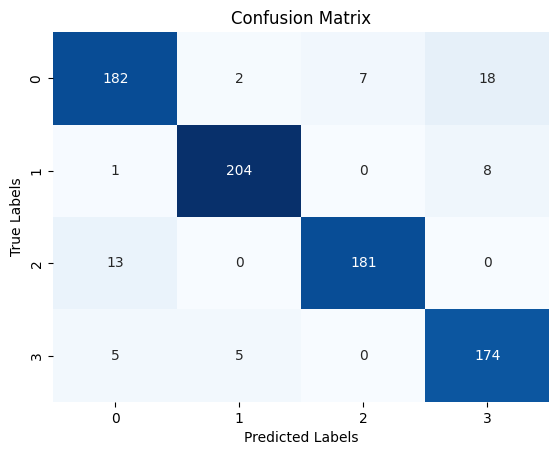

In [134]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

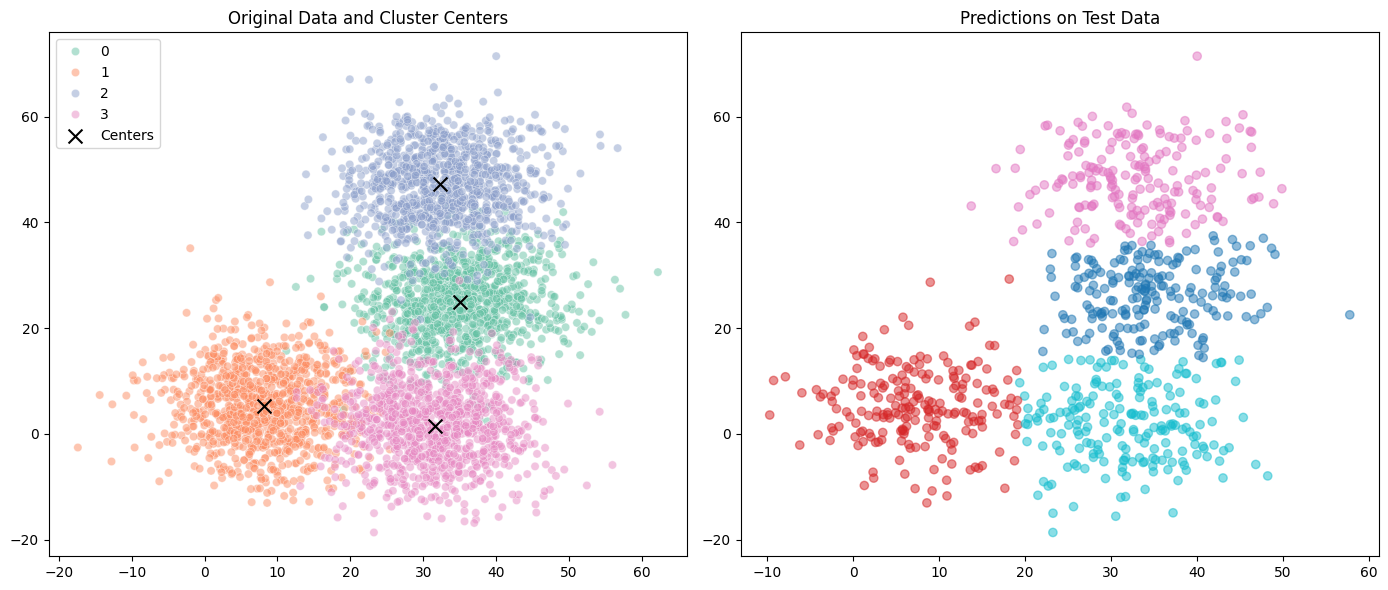

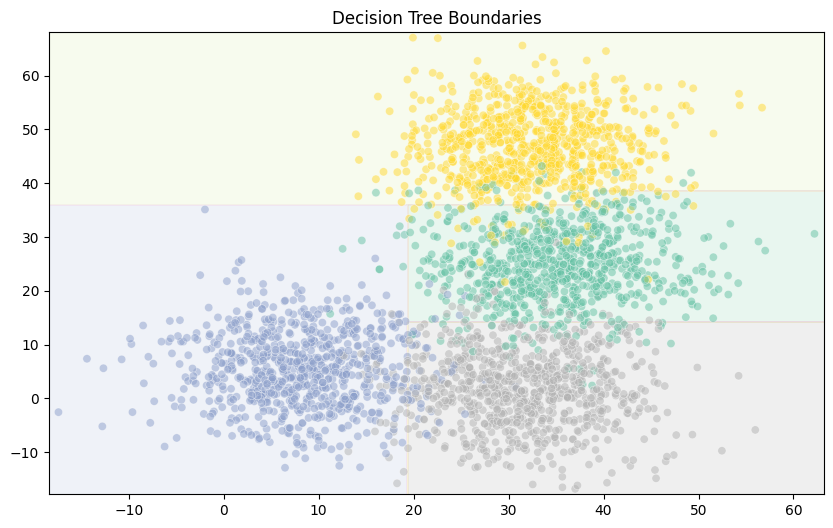

In [135]:
plot_clusters(data, centers, X_test, predicted, labels)
plot_decision_tree_boundaries(model, X_train, y_train)

## 🧪 Simple binary decision tree

In [136]:
class Node:
    """A node in the decision tree.

    Attributes:
        value (int | None): Class label if the node is a leaf, otherwise None.
        feature (int | None): Index of the feature to split on at this node.
        threshold (float | None): Threshold value for the split.
        left (Node | None): Left child node.
        right (Node | None): Right child node.
    """

    def __init__(
        self,
        feature: int | None = None,
        threshold: float | None = None,
        value: int | None = None,
    ) -> None:
        """Initialize a decision tree node.

        Args:
            feature (int | None): Feature index to split on, if applicable.
            threshold (float | None): Threshold value for the split, if applicable.
            value (int | None): Class label for a leaf node.
        """
        self.value: int | None = value
        self.feature: int | None = feature
        self.threshold: float | None = threshold
        self.left: "Node" | None = None
        self.right: "Node" | None = None


class MyDecisionTreeClassifier:
    """A simple binary decision tree classifier.

    This classifier recursively splits the data to minimize the impurity and
    forms a binary tree for classification.

    Attributes:
        max_depth (int): Maximum depth of the tree.
        criterion (Literal["gini", "entropy"]): Impurity criterion to use for splits.
            Defaults to "gini".
        min_samples_split (int): Minimum number of samples required to split an
            internal node.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node.
        max_features (int | float | Literal["sqrt", "log2"] | None, optional):
            Number or fraction of features to consider when looking for the
            best split. If None, use all features. If 'sqrt', use sqrt(n_features).
            If 'log2', use log2(n_features). If float, selects that fraction of
            total features. If int, selects exactly `max_features` features.
            Defaults to None.
        min_impurity_decrease (float): A node will be split if the impurity
            decrease is at least this value.
        bins (int | None): Optional number of bins to discretize continuous features
            for threshold selection. If None, no binning is applied.
        rng (Generator): NumPy random number generator instance.
        root (Node | None): Root node of the decision tree.
    """

    def __init__(
        self,
        max_depth: int,
        criterion: Literal["gini", "entropy"] = "gini",
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        max_features: int | float | Literal["sqrt", "log2"] | None = None,
        min_impurity_decrease: float = 0.0,
        bins: int | None = None,
        random_state: int | None = None,
    ) -> None:
        """Initialize the decision tree classifier.

        Args:
            max_depth (int): Maximum allowed depth of the tree.
            criterion (Literal["gini", "entropy"]): Impurity criterion to use for
                splits. Defaults to "gini".
            min_samples_split (int, optional): Minimum number of samples required to
                split an internal node. Defaults to 2.
            min_samples_leaf (int, optional): Minimum number of samples required to be
                at a leaf node. Defaults to 1.
            max_features (int | float | Literal["sqrt", "log2"] | None, optional):
                Number or fraction of features to consider when looking for the
                best split. If None, use all features. If 'sqrt', use sqrt(n_features).
                If 'log2', use log2(n_features). If float, selects that fraction of
                total features. If int, selects exactly `max_features` features.
                Defaults to None.
            min_impurity_decrease (float, optional): Minimum impurity decrease
                required to make a split. Defaults to 0.0.
            bins (int | None): Optional number of bins to discretize continuous features
                for threshold selection. If None, no binning is applied.
            random_state (int | None, optional): Random seed for reproducibility.
                Defaults to None.
        """
        self.max_depth: int = max_depth
        self.criterion: str = criterion
        self.min_samples_split: int = min_samples_split
        self.min_samples_leaf: int = min_samples_leaf
        self.max_features: int | float | str | None = max_features
        self.min_impurity_decrease: float = min_impurity_decrease
        self.bins: int | None = bins
        self.rng: RandomGenerator = np.random.default_rng(random_state)
        self.root: Node | None = None

    def _get_features(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Select a subset of feature indices based on the `max_features` parameter.

        This method determines how many features to consider at each split based on
        the type and value of `max_features`:
            - If int, selects exactly `max_features` features.
            - If float, selects that fraction of total features.
            - If 'sqrt', selects sqrt(n_features).
            - If 'log2', selects log2(n_features).
            - If None: use all features.

        Ensures at least one feature is selected and does not exceed the number
        of available features.

        Args:
            X (NDArray[np.float64]): Input data of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Array of selected feature indices.

        Raises:
            ValueError: If `max_features` is not an int, float, "sqrt", or "log2".
        """
        feature_count = X.shape[1]

        if isinstance(self.max_features, int):
            feature_count = self.max_features
        elif isinstance(self.max_features, float):
            feature_count = int(feature_count * self.max_features)
        elif self.max_features == "sqrt":
            feature_count = int(np.sqrt(feature_count))
        elif self.max_features == "log2":
            feature_count = int(np.log2(feature_count))
        elif self.max_features is not None:
            raise ValueError(f"Unsupported max_features: {self.max_features}")

        feature_count = max(1, min(feature_count, X.shape[1]))
        return self.rng.choice(X.shape[1], feature_count, replace=False)

    def _impurity(self, y: NDArray[np.float64]) -> float:
        """Compute the impurity of a set of class labels using the specified criterion.

        Supports both "gini" and "entropy" as impurity measures.

        Args:
            y (NDArray[np.float64]): Array of class labels.

        Returns:
            float: Computed impurity value.

        Raises:
            ValueError: If an unsupported criterion is specified.
        """
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()

        if self.criterion == "gini":
            return 1.0 - np.sum(probabilities**2)
        elif self.criterion == "entropy":
            return -np.sum(probabilities * np.log2(probabilities + 1e-10))
        else:
            raise ValueError(f"Unknown criterion: {self.criterion}")

    def _split_dataset(
        self,
        X: NDArray[np.float64],
        y: NDArray[np.float64],
        feature_index: int,
        threshold: float,
    ) -> tuple[
        NDArray[np.float64],
        NDArray[np.float64],
        NDArray[np.float64],
        NDArray[np.float64],
    ]:
        """Split the dataset based on a feature and a threshold.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Corresponding labels.
            feature_index (int): Index of the feature to split on.
            threshold (float): Threshold value for the split.

        Returns:
            Tuple of:
                X_left (NDArray[np.float64]): Features where feature <= threshold.
                y_left (NDArray[np.float64]): Labels for X_left.
                X_right (NDArray[np.float64]): Features where feature > threshold.
                y_right (NDArray[np.float64]): Labels for X_right.
        """
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _get_thresholds_from_bins(
        self, x_column: NDArray[np.float64]
    ) -> NDArray[np.float64]:
        """Compute candidate thresholds.

        If `bins` is None or less than 1, thresholds are computed as midpoints between
        sorted unique values of `x_column`. Otherwise, thresholds are computed
        as midpoints between histogram bin edges based on the specified number of bins.

        Args:
            x_column (NDArray[np.float64]): 1D array of feature values.

        Returns:
            NDArray[np.float64]: Array of unique candidate thresholds.
        """
        if self.bins is None or self.bins < 1:
            x_column_sorted = np.sort(np.unique(x_column))
            thresholds = (x_column_sorted[:-1] + x_column_sorted[1:]) / 2
        else:
            bin_edges = np.histogram_bin_edges(x_column, bins=self.bins)
            thresholds = (bin_edges[:-1] + bin_edges[1:]) / 2

        return thresholds

    def _best_split(
        self, X: NDArray[np.float64], y: NDArray[np.float64]
    ) -> tuple[int, float]:
        """Find the best feature and threshold to split the dataset.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Corresponding labels.

        Returns:
            tuple[int, float]: Best feature index and corresponding threshold.
        """
        best_feature: int | None = None
        best_threshold: float | None = None
        best_gain: float = float("-inf")

        current_impurity = self._impurity(y)

        for feature_index in self._get_features(X):
            thresholds = self._get_thresholds_from_bins(X[:, feature_index])
            for threshold in thresholds:
                _, y_left, _, y_right = self._split_dataset(
                    X, y, feature_index, threshold
                )
                if (
                    len(y_left) < self.min_samples_leaf
                    or len(y_right) < self.min_samples_leaf
                ):
                    continue

                left_impurity = self._impurity(y_left)
                right_impurity = self._impurity(y_right)
                weighted_impurity = (
                    len(y_left) * left_impurity + len(y_right) * right_impurity
                ) / len(y)
                impurity_decrease = current_impurity - weighted_impurity
                if (
                    impurity_decrease <= best_gain
                    or impurity_decrease < self.min_impurity_decrease
                ):
                    continue

                best_gain = impurity_decrease
                best_threshold = threshold
                best_feature = feature_index

        return best_feature, best_threshold

    def build(
        self, X: NDArray[np.float64], y: NDArray[np.float64], depth: int = 0
    ) -> Node:
        """Recursively build the decision tree.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Labels.
            depth (int, optional): Current depth of the tree. Defaults to 0.

        Returns:
            Node: Root node of the constructed subtree.
        """
        if (
            len(np.unique(y)) == 1
            or len(y) < self.min_samples_split
            or depth == self.max_depth
        ):
            leaf_value = np.bincount(y).argmax()
            return Node(value=leaf_value)

        feature, threshold = self._best_split(X, y)
        if feature is None:
            leaf_value = np.bincount(y).argmax()
            return Node(value=leaf_value)

        X_left, y_left, X_right, y_right = self._split_dataset(X, y, feature, threshold)

        node = Node(feature=feature, threshold=threshold)
        node.left = self.build(X_left, y_left, depth + 1)
        node.right = self.build(X_right, y_right, depth + 1)

        return node

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Train the decision tree on the provided dataset.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).
            y (NDArray[np.float64]): Labels of shape (n_samples,).
        """
        self.root = self.build(X, y)

    def _predict_one(self, x: NDArray[np.float64], node: Node | None = None) -> int:
        """Predict the label for a single data point.

        Args:
            x (NDArray[np.float64]): Input feature vector.
            node (Node | None, optional): Current node in the tree. Defaults to root.

        Returns:
            int: Predicted class label.
        """
        if node is None:
            node = self.root

        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        return self._predict_one(x, node.right)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Predict the labels for a batch of input samples.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted labels for each sample.
        """
        return np.array([self._predict_one(x) for x in X])

In [137]:
# Create and train the model
model = MyDecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
predicted = model.predict(X_test)

Accuracy:  0.9263
Precision: 0.9275
Recall:    0.9263
F1 Score:  0.9264


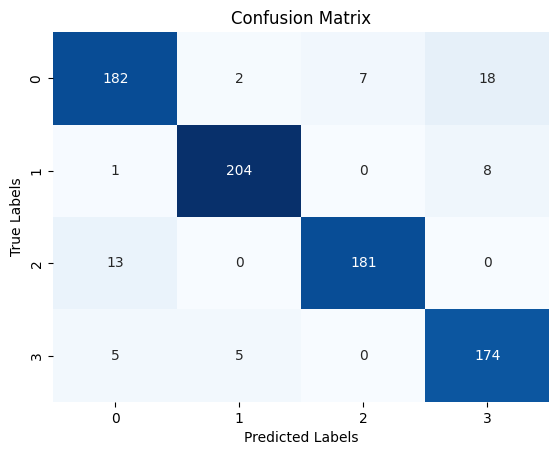

In [138]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

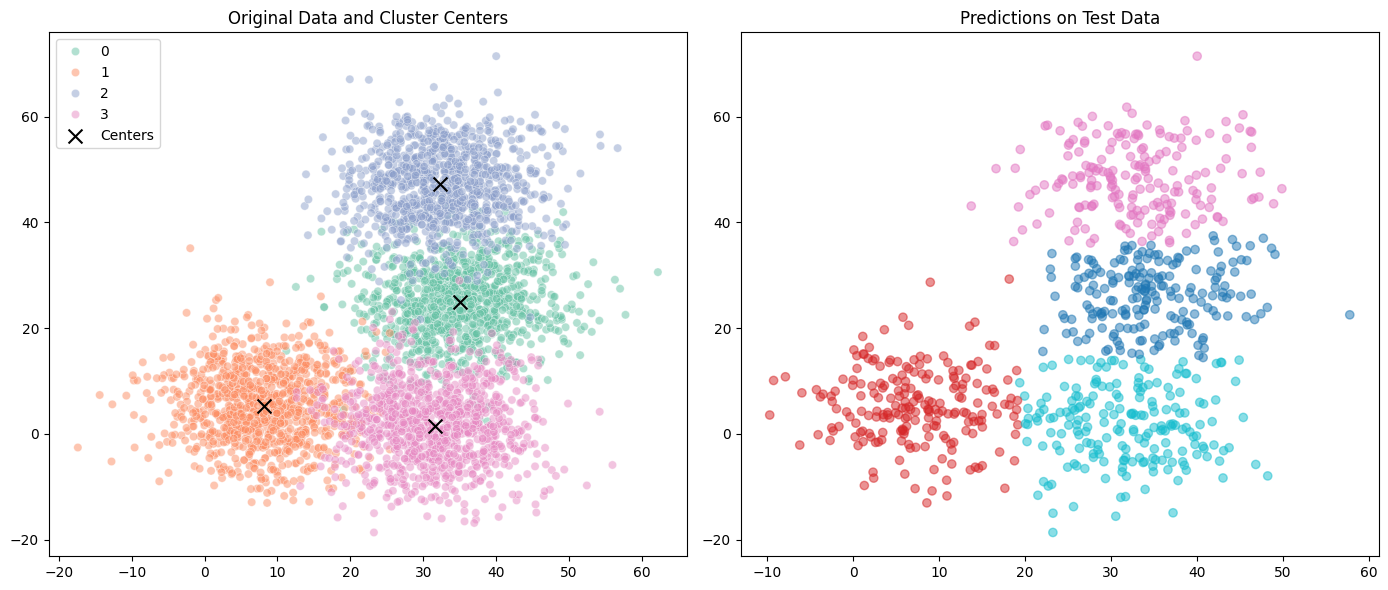

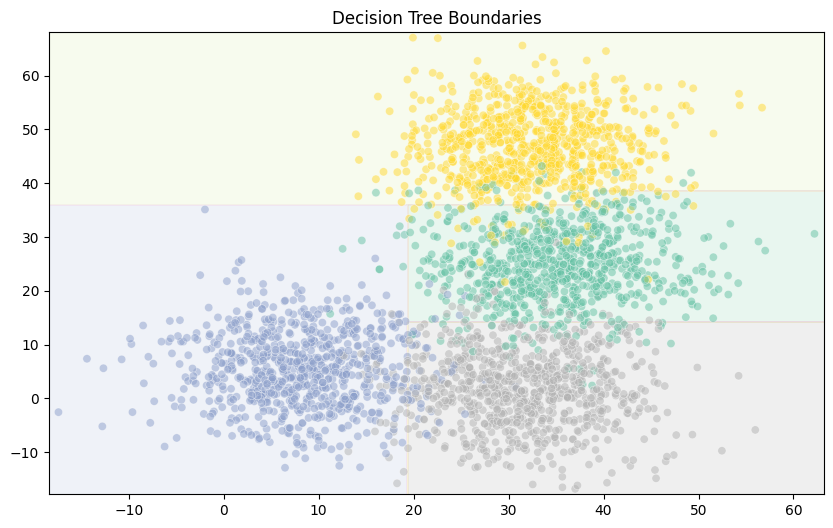

In [139]:
plot_clusters(data, centers, X_test, predicted, labels)
plot_decision_tree_boundaries(model, X_train, y_train)

---

In [140]:
# Create and train the model
model = MyDecisionTreeClassifier(max_depth=3, random_state=42, bins=16)
model.fit(X_train, y_train)

# Predict on test data
predicted = model.predict(X_test)

Accuracy:  0.9325
Precision: 0.9349
Recall:    0.9325
F1 Score:  0.9328


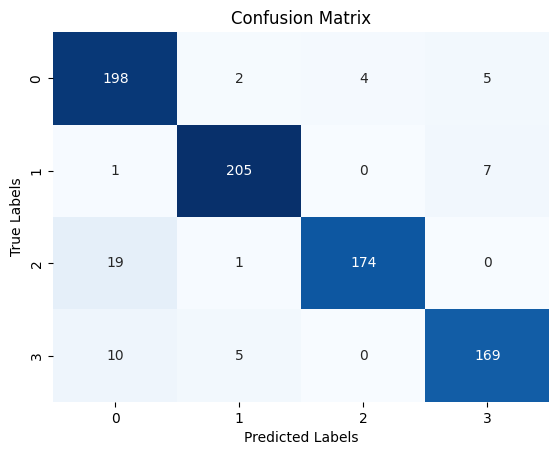

In [141]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

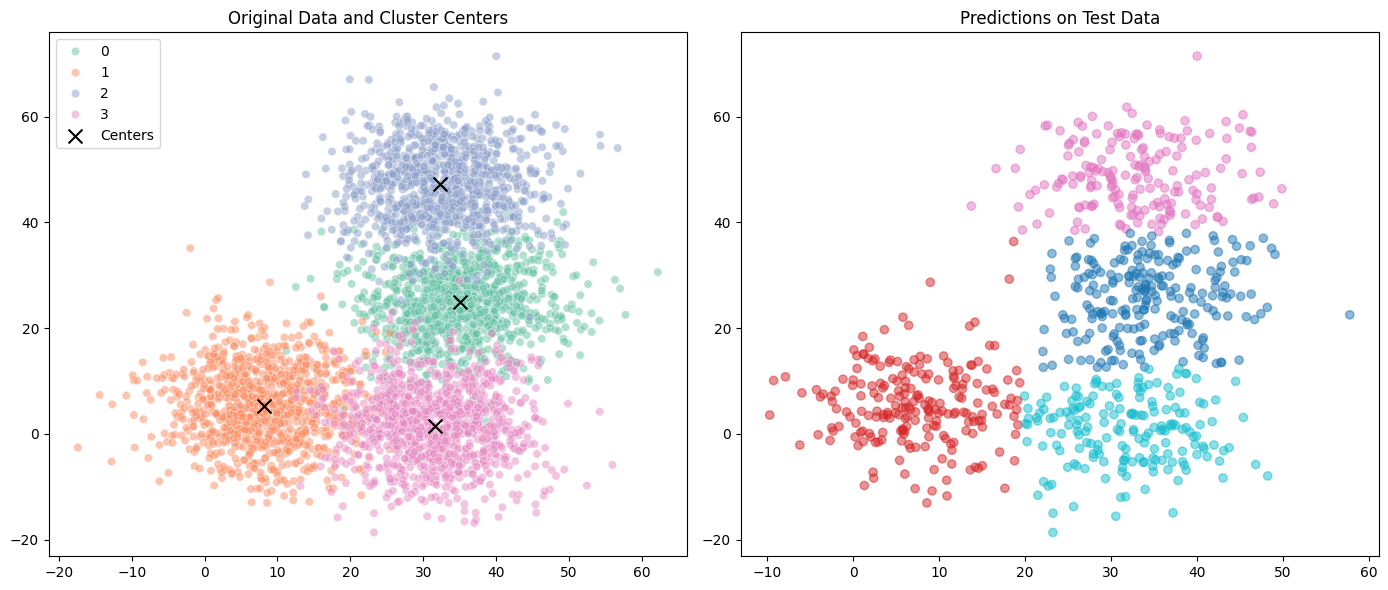

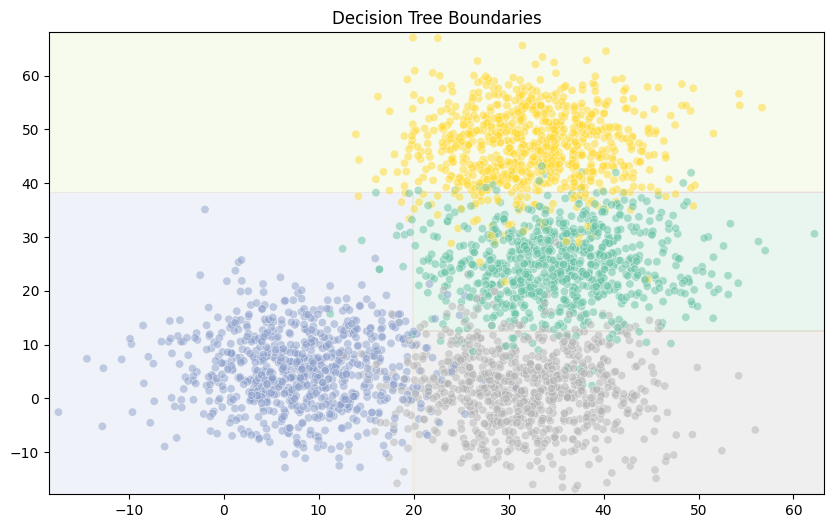

In [142]:
plot_clusters(data, centers, X_test, predicted, labels)
plot_decision_tree_boundaries(model, X_train, y_train)